# **Project : Prediction of music genre**
<hr>

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Sorapas Weerakul 63340500064<br>
Athimet Aiewcharoen 63340500068
<hr>

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs import *
%matplotlib inline

import pandas_profiling as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Fetures selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2,VarianceThreshold
from sklearn.decomposition import PCA

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, Birch, MeanShift, OPTICS
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestCentroid , KNeighborsClassifier, NearestNeighbors, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import InstanceHardnessThreshold, RandomUnderSampler, NearMiss

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix , silhouette_score , rand_score , adjusted_mutual_info_score, mutual_info_score, auc

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# For Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Imputer 
from sklearn.impute import SimpleImputer, KNNImputer

# Make image directory (img)
import os
currDir = os.getcwd()
if not os.path.exists('img'):
    os.mkdir('img')

# Set global random seed
np.random.seed(1)

In [6]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

cmap = ListedColormap([(0.235, 0.635, 0.827), (0.863, 0.863, 0.863)])
pieCmap = get_cmap('plasma')
snsPalette = [(0.235, 0.635, 0.827), (0.475, 0.027, 0.082)]
bgColor = (0.059, 0.067, 0.102)
axBGColor = (0.863, 0.863, 0.863)
barColor = (0.235, 0.635, 0.827)
axTextColor = (0.9, 0.9, 0.9)
textColor = (0, 0, 0)
titleColor = (0.9, 0.9, 0.9)
plt.rcParams['figure.facecolor'] = bgColor
plt.rcParams['axes.facecolor'] = axBGColor
plt.rcParams['axes.edgecolor'] = axTextColor
plt.rcParams['axes.labelcolor'] = axTextColor
plt.rcParams['xtick.color'] = axTextColor
plt.rcParams['ytick.color'] = axTextColor
plt.rcParams['text.color'] = textColor
plt.rcParams['axes.titlecolor'] = titleColor
plt.rcParams['legend.labelcolor'] = titleColor

plotlyGridcolor = 'rgba(0.9, 0.9, 0.9, 0.3)'

In [7]:
def modelTestProcess(df, getdummy = 0,verbose=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    df_model = df.copy()
    if getdummy == 1:
        df_model = pd.get_dummies(df_model, columns=['key','mode'],drop_first=True)
    X = df_model.drop(['music_genre'], axis=1)
    y = df_model['music_genre']
    # Scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # Splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    # Model
    LR_clf = LogisticRegression(n_jobs=-1, random_state=1,multi_class='multinomial')
    DT_clf = DecisionTreeClassifier(random_state=1)
    RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
    KNN_clf = KNeighborsClassifier(n_jobs=-1)
    MLPC_clf = MLPClassifier(random_state=1)
    # SVC_clf = LinearSVC(random_state=1,multi_class='crammer_singer') # U take too much time
    modeldict = {'Logistic Regression Model':LR_clf, 'Decision Tree Model':DT_clf, 'Random Forest Model':RF_clf,
                'KNN Model':KNN_clf, 'MLPC Model':MLPC_clf}
    # Training
    for modelname, model in modeldict.items():
        model.fit(X_train, y_train)
        verboseprint(f'{modelname} trained.')
    # Testing
    resultdict = {}
    confusion_matrix_dict = {}
    f1scoredict = {}
    for modelname, model in modeldict.items():
        y_pred = model.predict(X_test)
        resultdict[modelname] = classification_report(y_test, y_pred)
        confusion_matrix_dict[modelname] = confusion_matrix(y_test, y_pred)
        f1scoredict[modelname] = f1_score(y_test, y_pred, average='weighted')
    for key, value in resultdict.items():
        verboseprint(f'Classification report of {key}',':\n',value)
        verboseprint(f'F1 score of {key} is {f1scoredict[key]}\n','-'*50)
    for key, value in f1scoredict.items():
        print(f'{key} (F1 score) : {value}')
    return modeldict,resultdict,confusion_matrix_dict,f1scoredict

In [8]:
df = pd.read_csv('Data/data.csv')

### **Handle Missing Values**

เนื่องจาก Missing values มีจำนวนมาก 18.8% ของ Dataset ทั้งหมด จึงเลือกที่จะ Replace แทนที่จะ Remove โดยเลือกที่จะ Replace ด้วยค่าต่างในการทดลองนี้โดยเราพิจารณาใช้

- ค่าเฉลี่ยของคอลัมน์ที่มี Missing values
- ค่าที่มีความถี่สูงสุดของคอลัมน์ที่มี Missing values
- Multivariate Imputation by Chained Equations(mice)
- K-Nearest Neighbors (KNN) Imputer

In [9]:
df_vis = df.copy()
df_impute =  df.copy()

In [10]:
def plotForImpute(df, feature, df2 = None, prefix = ['','']):
    df = df.copy()
    df_Electronic = df[df['music_genre'] == 'Electronic']
    df_Anime = df[df['music_genre'] == 'Anime']
    df_Jazz = df[df['music_genre'] == 'Jazz']
    df_Alternative = df[df['music_genre'] == 'Alternative']
    df_Country = df[df['music_genre'] == 'Country']
    df_Blues = df[df['music_genre'] == 'Blues']
    df_Rap = df[df['music_genre'] == 'Rap']
    df_Rock = df[df['music_genre'] == 'Rock']
    df_Classical = df[df['music_genre'] == 'Classical']
    df_Hip_Hop = df[df['music_genre'] == 'Hip-Hop']
    if type(df2) == type(None):
        plotDflist = [df_Electronic, df_Anime, df_Jazz, df_Alternative, df_Country, df_Blues, df_Rap, df_Rock, df_Classical, df_Hip_Hop]
        titlelist = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Blues', 'Rap', 'Rock', 'Classical', 'Hip-Hop']
        row , col = 2, 5
        targetPlot = feature
        imputeHists, axes = plt.subplots(row, col, figsize=(30, 10))
    else :
        df2 = df2.copy()
        df2_Electronic = df2[df2['music_genre'] == 'Electronic']
        df2_Anime = df2[df2['music_genre'] == 'Anime']
        df2_Jazz = df2[df2['music_genre'] == 'Jazz']
        df2_Alternative = df2[df2['music_genre'] == 'Alternative']
        df2_Country = df2[df2['music_genre'] == 'Country']
        df2_Blues = df2[df2['music_genre'] == 'Blues']
        df2_Rap = df2[df2['music_genre'] == 'Rap']
        df2_Rock = df2[df2['music_genre'] == 'Rock']
        df2_Classical = df2[df2['music_genre'] == 'Classical']
        df2_Hip_Hop = df2[df2['music_genre'] == 'Hip-Hop']
        plotDflist = [df_Electronic, df2_Electronic, df_Anime, df2_Anime, df_Jazz, df2_Jazz, df_Alternative, df2_Alternative, df_Country, df2_Country, df_Blues, df2_Blues, df_Rap, df2_Rap, df_Rock, df2_Rock, df_Classical, df2_Classical, df_Hip_Hop, df2_Hip_Hop]
        titlelist = ['Electronic', 'Electronic', 'Anime', 'Anime', 'Jazz', 'Jazz', 'Alternative', 'Alternative', 'Country', 'Country', 'Blues', 'Blues', 'Rap', 'Rap', 'Rock', 'Rock', 'Classical', 'Classical', 'Hip-Hop', 'Hip-Hop']
        row , col = 5, 2
        targetPlot = feature
        imputeHists, axes = plt.subplots(2*row, col, figsize=(20, 60))
    for i, df in enumerate(plotDflist):
            ax = axes[i//col, i%col]
            sns.histplot(df[targetPlot], ax=ax, color=snsPalette[0], kde=True)
            if i%2 == 0:
                ax.set_title(f'{prefix[0]}'+titlelist[i])
            else:
                ax.set_title(f'{prefix[1]}'+titlelist[i])
            ax.set_xlabel(targetPlot)
            ax.set_ylabel('Count')
            ax.set_facecolor(axBGColor)
    return imputeHists

#### **Plotting Histogram**

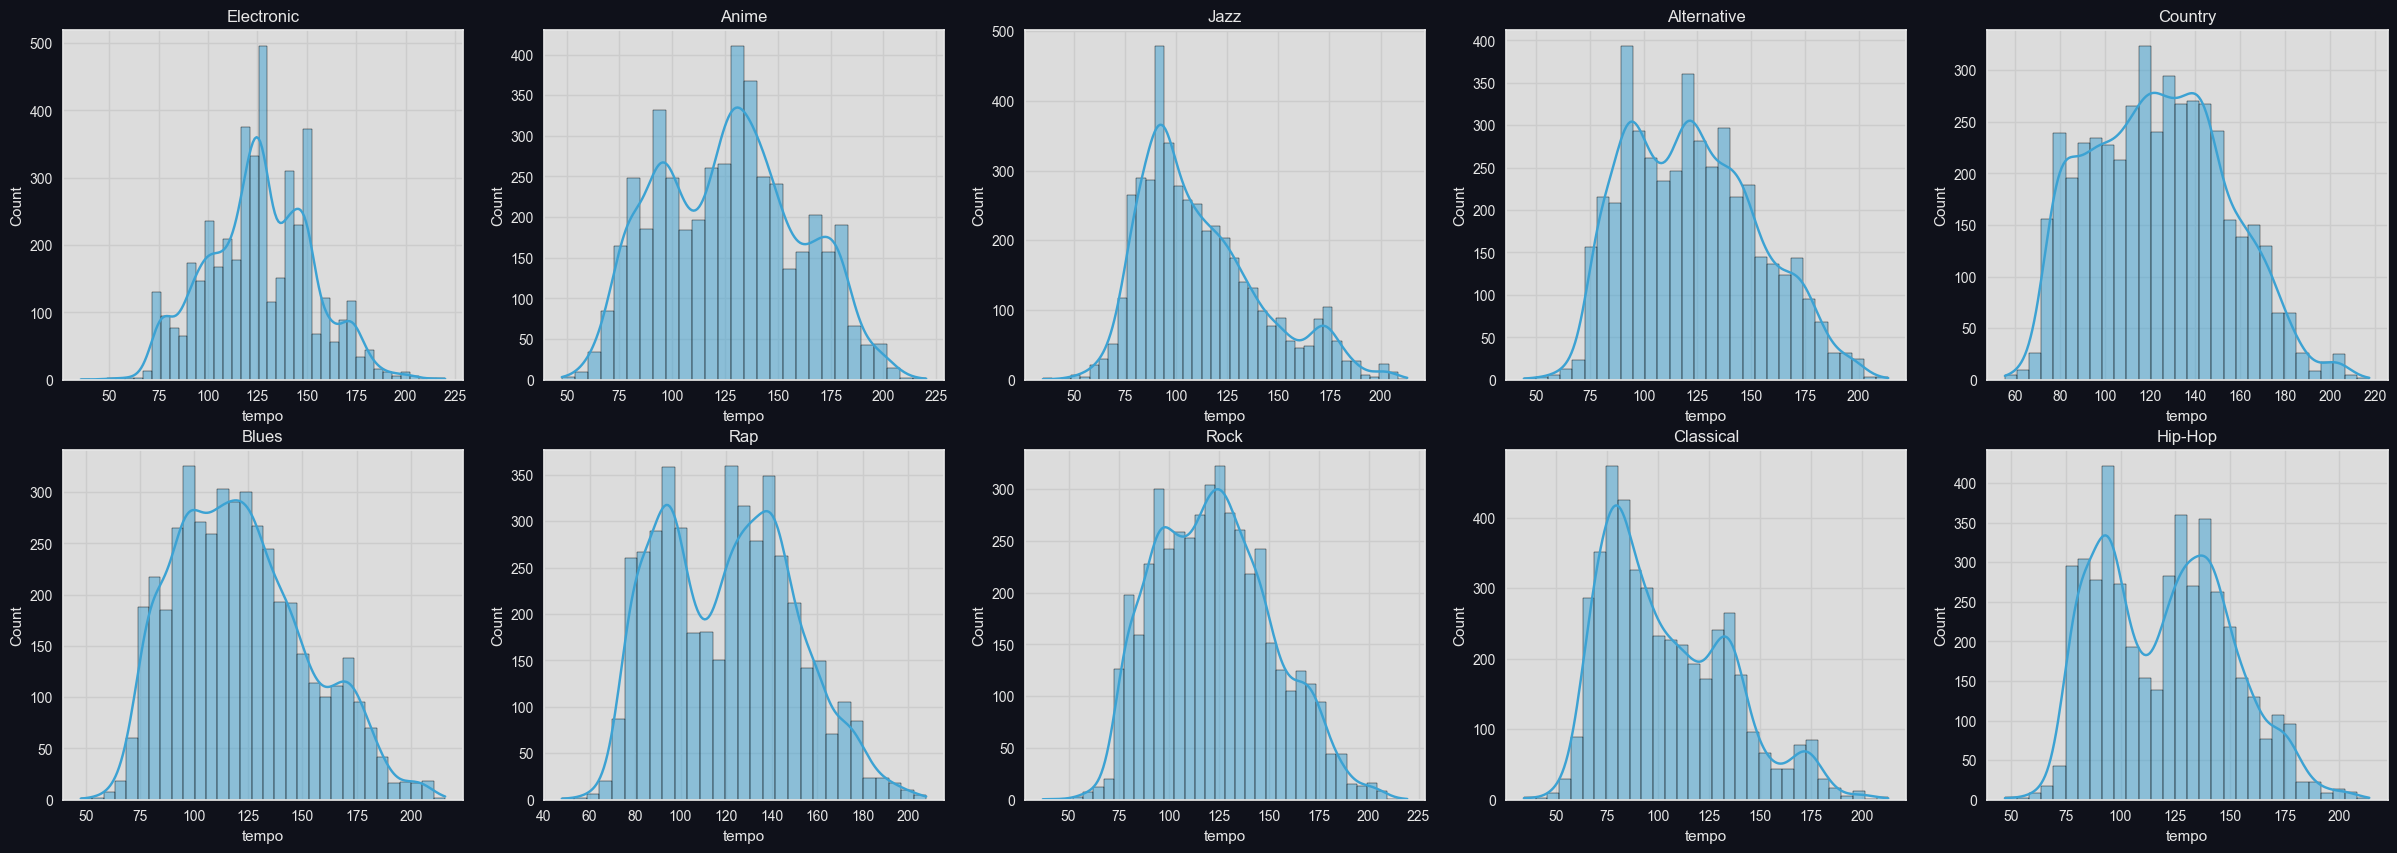

In [11]:
imputeHists_tempo = plotForImpute(df_vis, 'tempo')

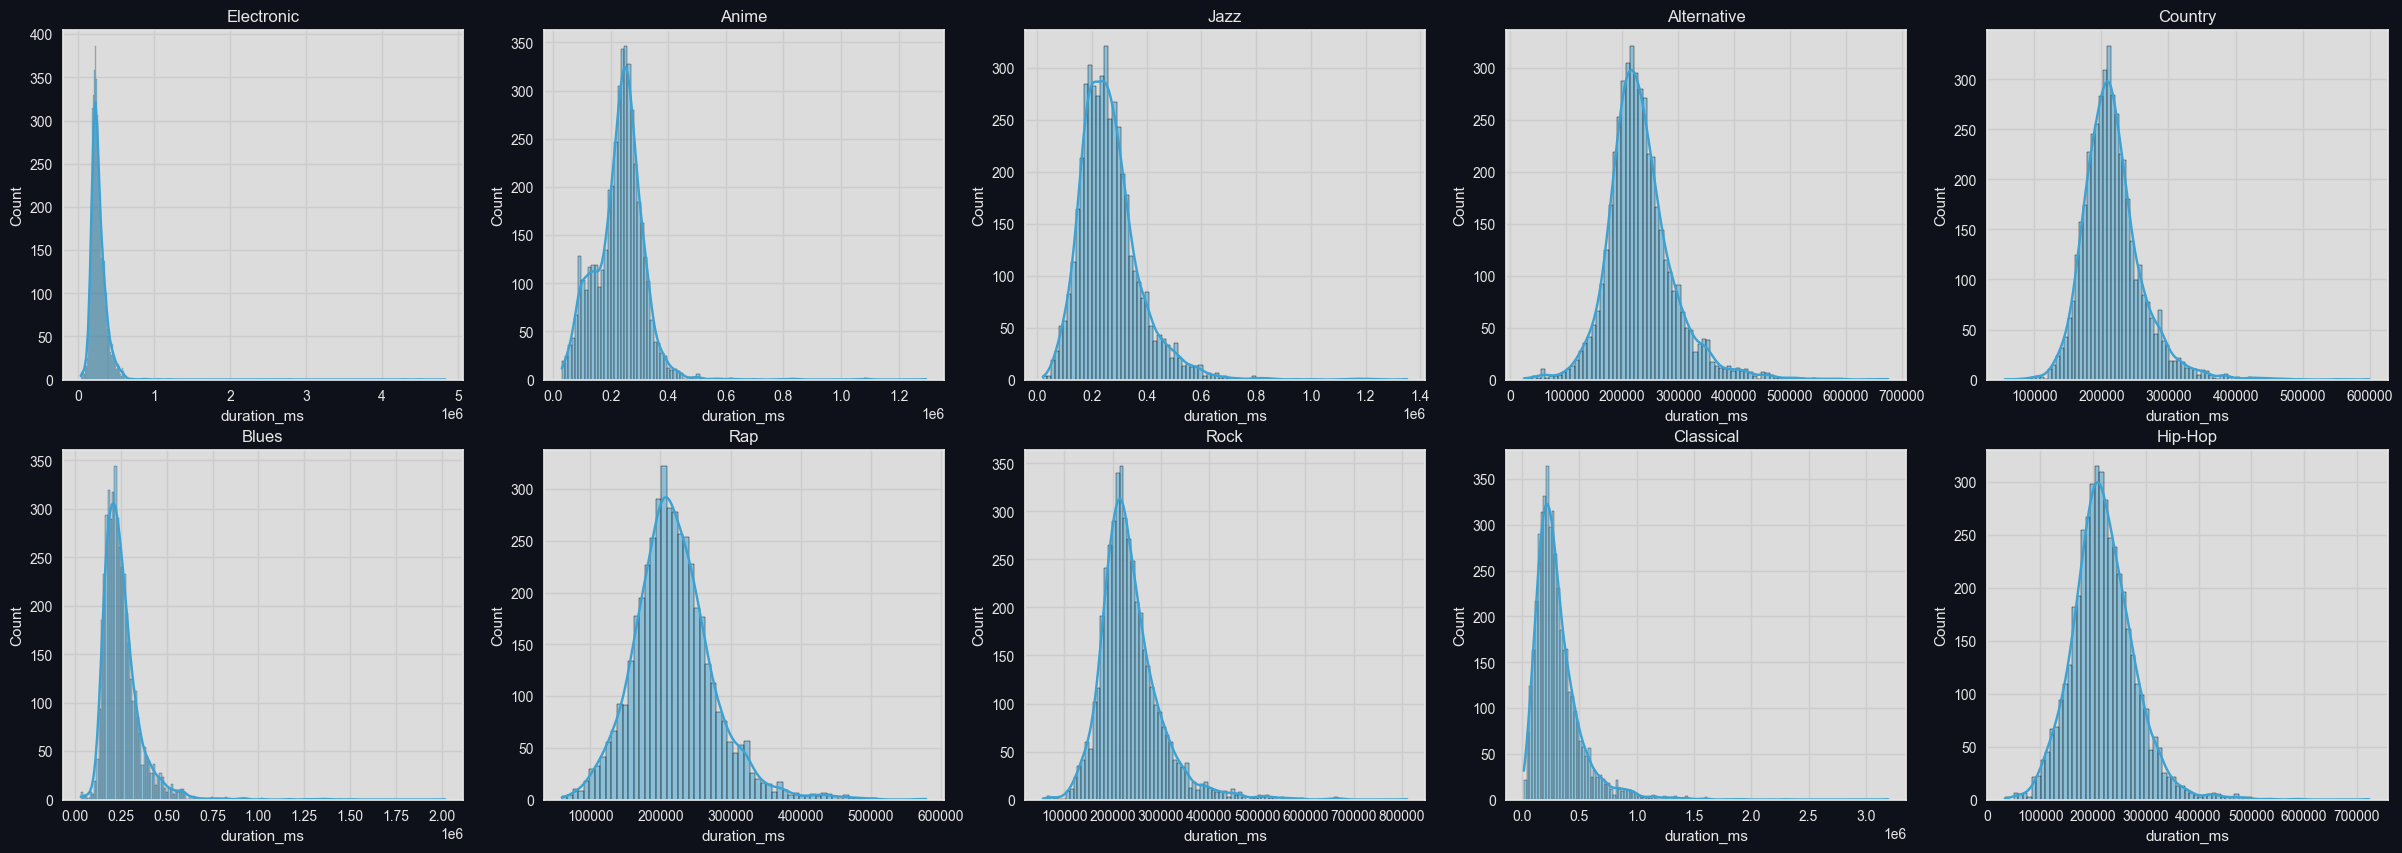

In [12]:
imputeHists_duration_ms = plotForImpute(df_vis, 'duration_ms')

โดยเราจะ Plot Histogram ของคอลัมน์ที่มี Missing values ออกมาเพื่อพิจารณาการกระจายของตัวของข้อมูล โดยเราจะพยายามที่จะเลือก Method ในการ Replace ที่มีการกระจายของข้อมูลใกล้เคียงกับข้อมูลตั้งต้นมากที่สุดเพื่อไม่ให้การทำ Imputation ทำให้ข้อมูลไมาแสดงถึงการกระจายของข้อมูลจริง 

#### **Imputation Using Mean,Most Frequent**

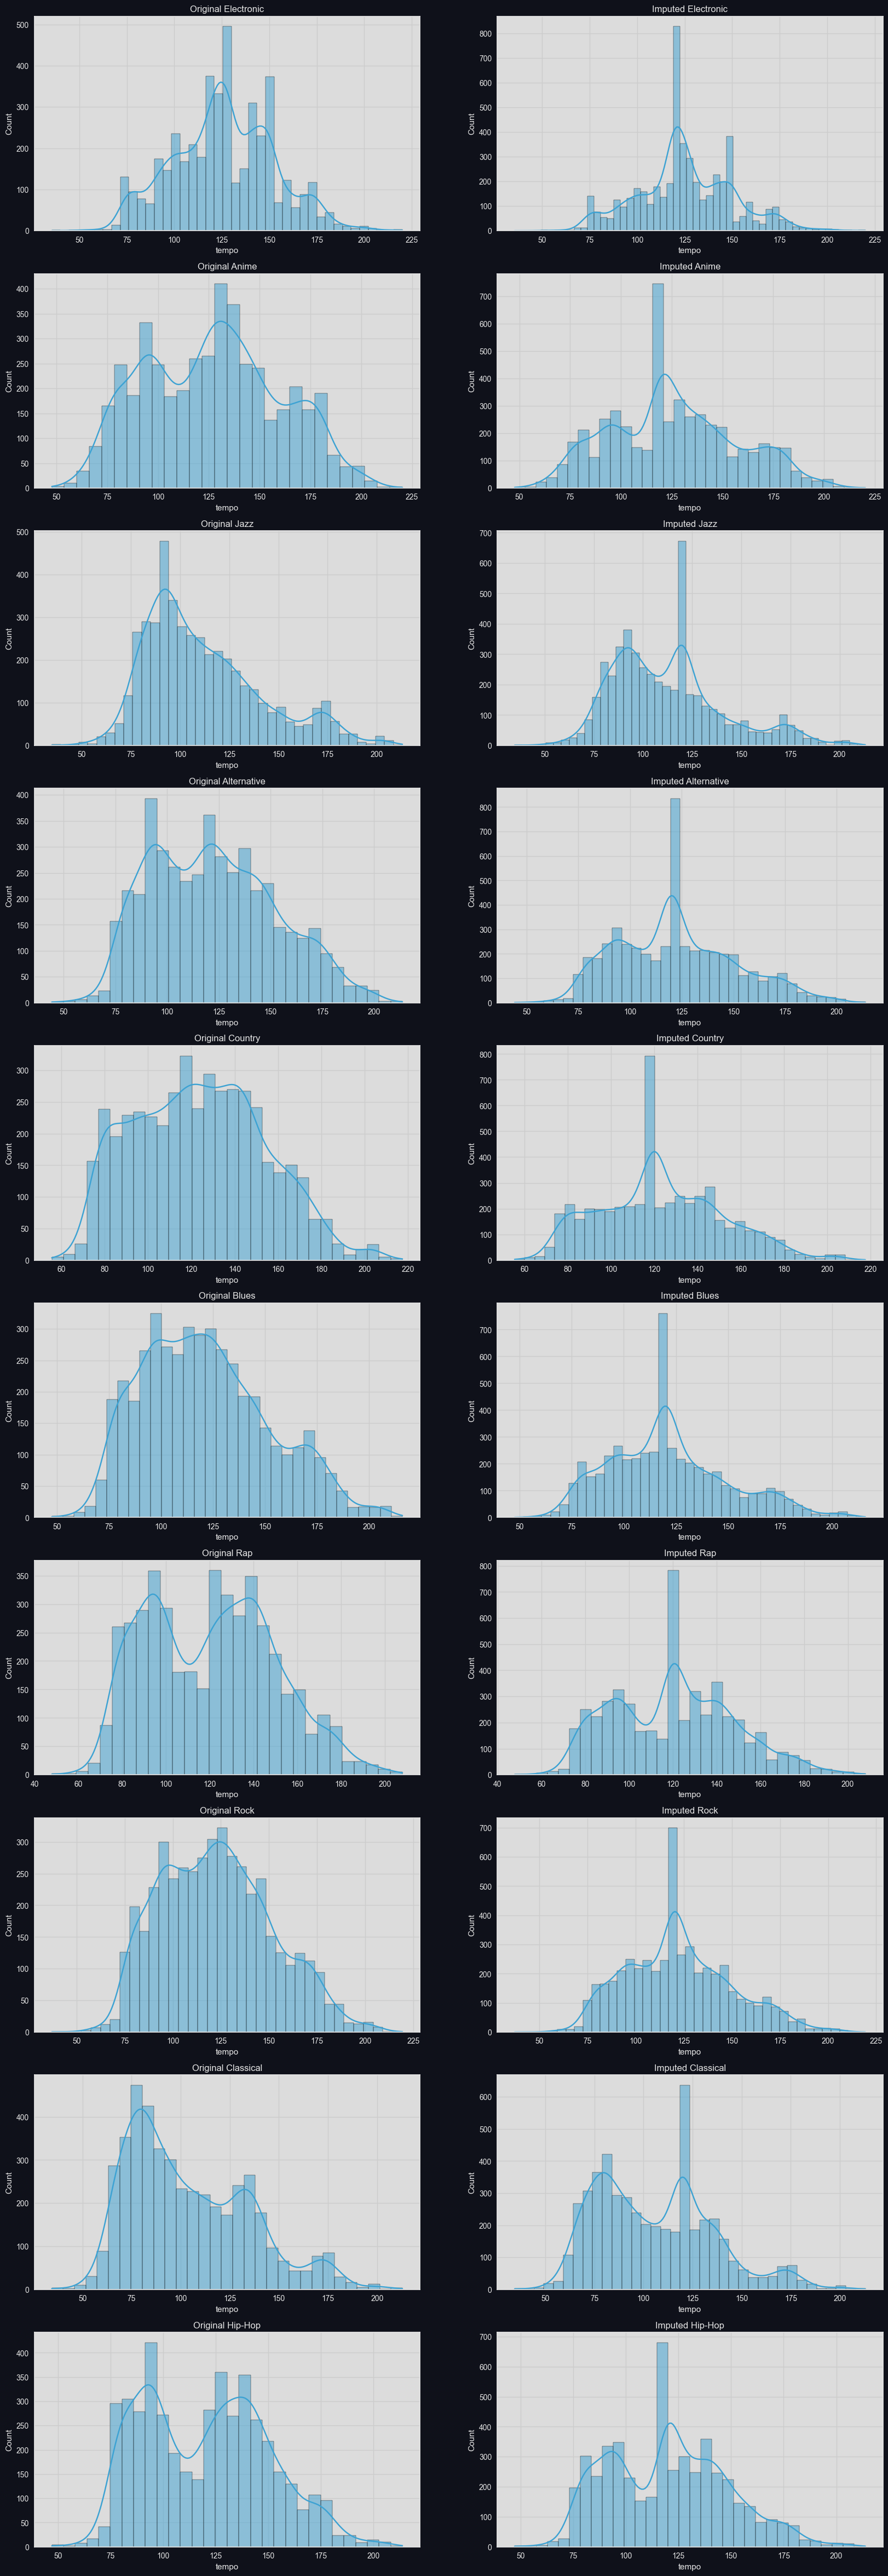

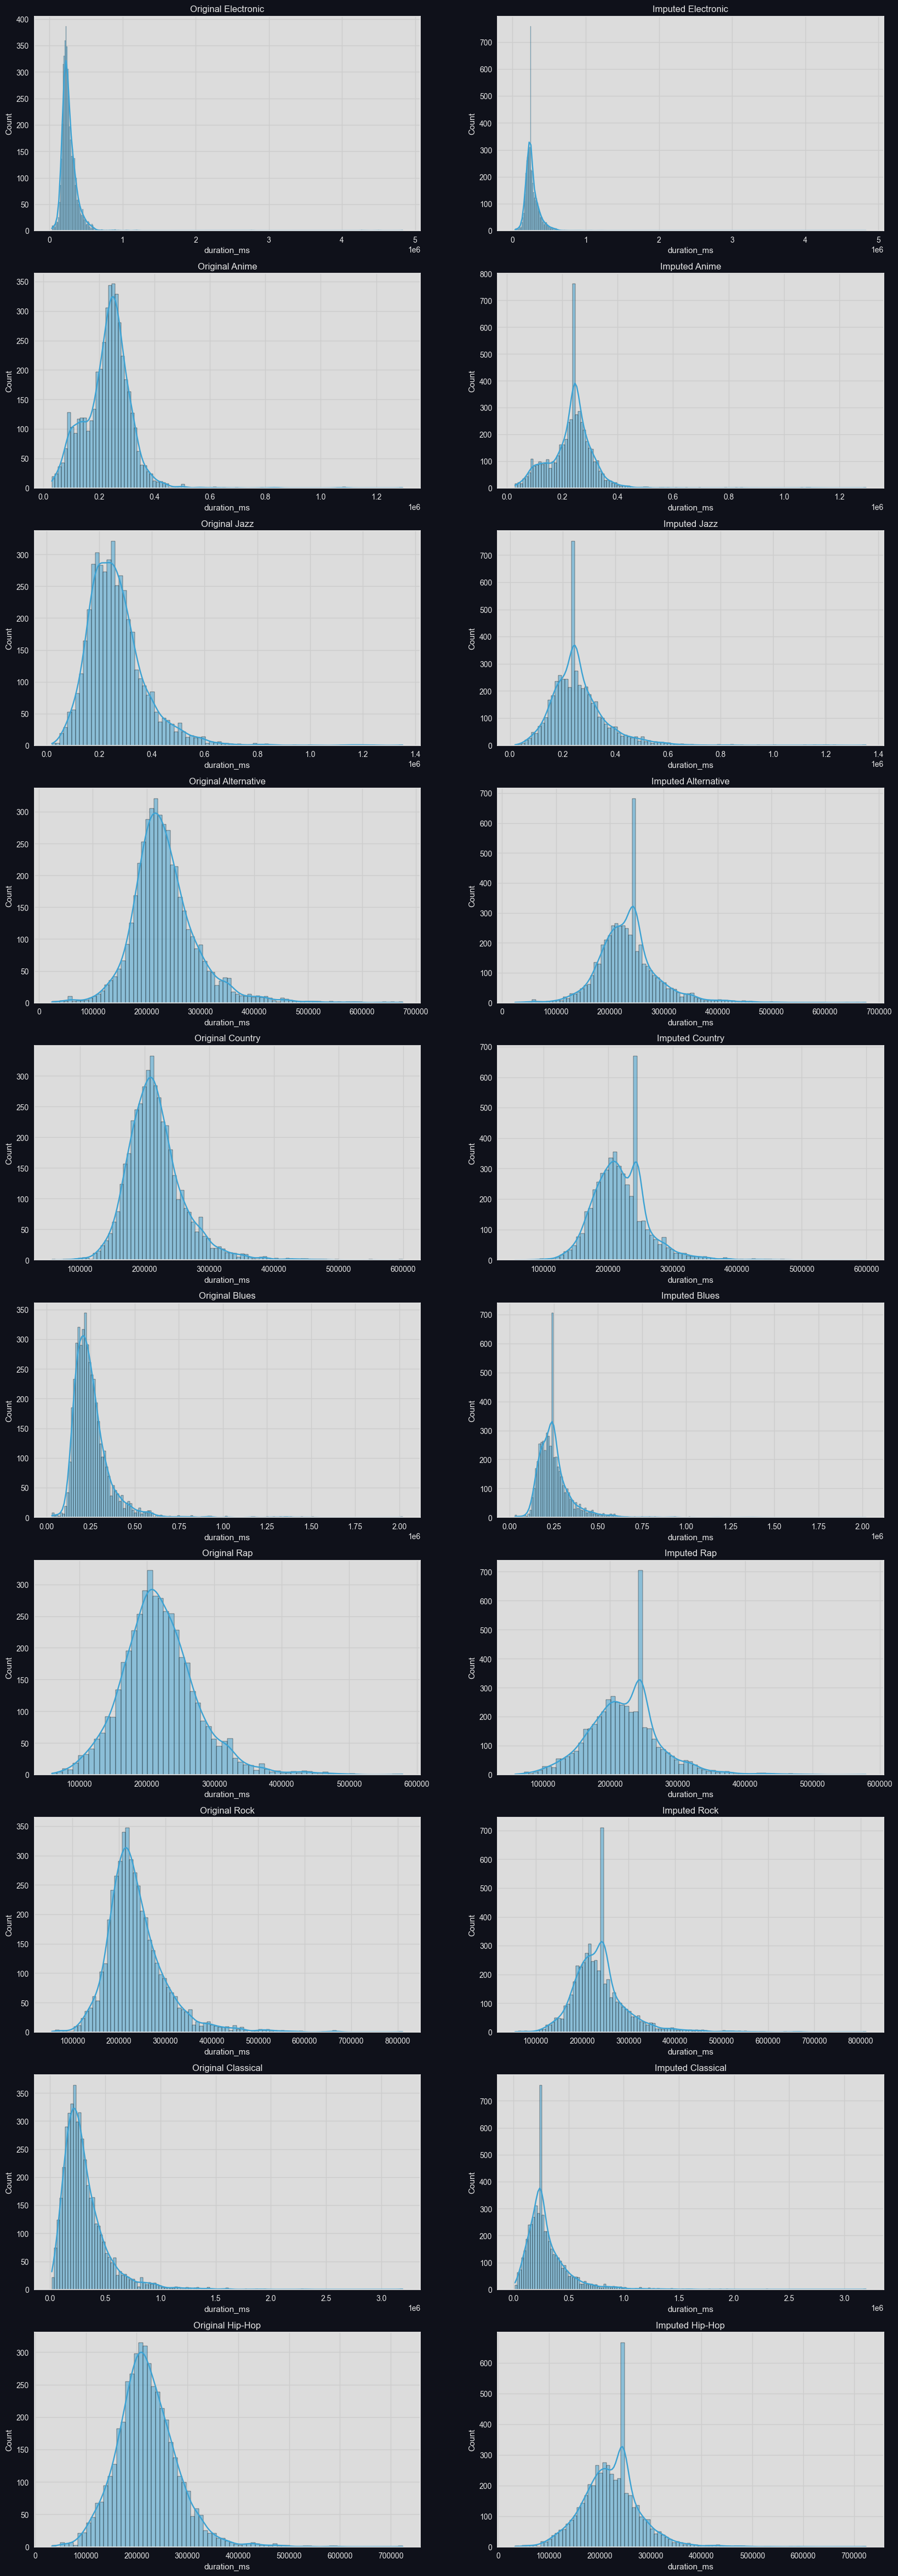

In [13]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_impute_mean = df_impute.copy()
df_impute_mean['tempo'] = imp_mean.fit_transform(df_impute_mean[['tempo']])
df_impute_mean['duration_ms'] = imp_mean.fit_transform(df_impute_mean[['duration_ms']])
imputeHists_mean_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mean, ['Original ','Imputed '])
imputeHists_mean_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mean, ['Original ','Imputed '])

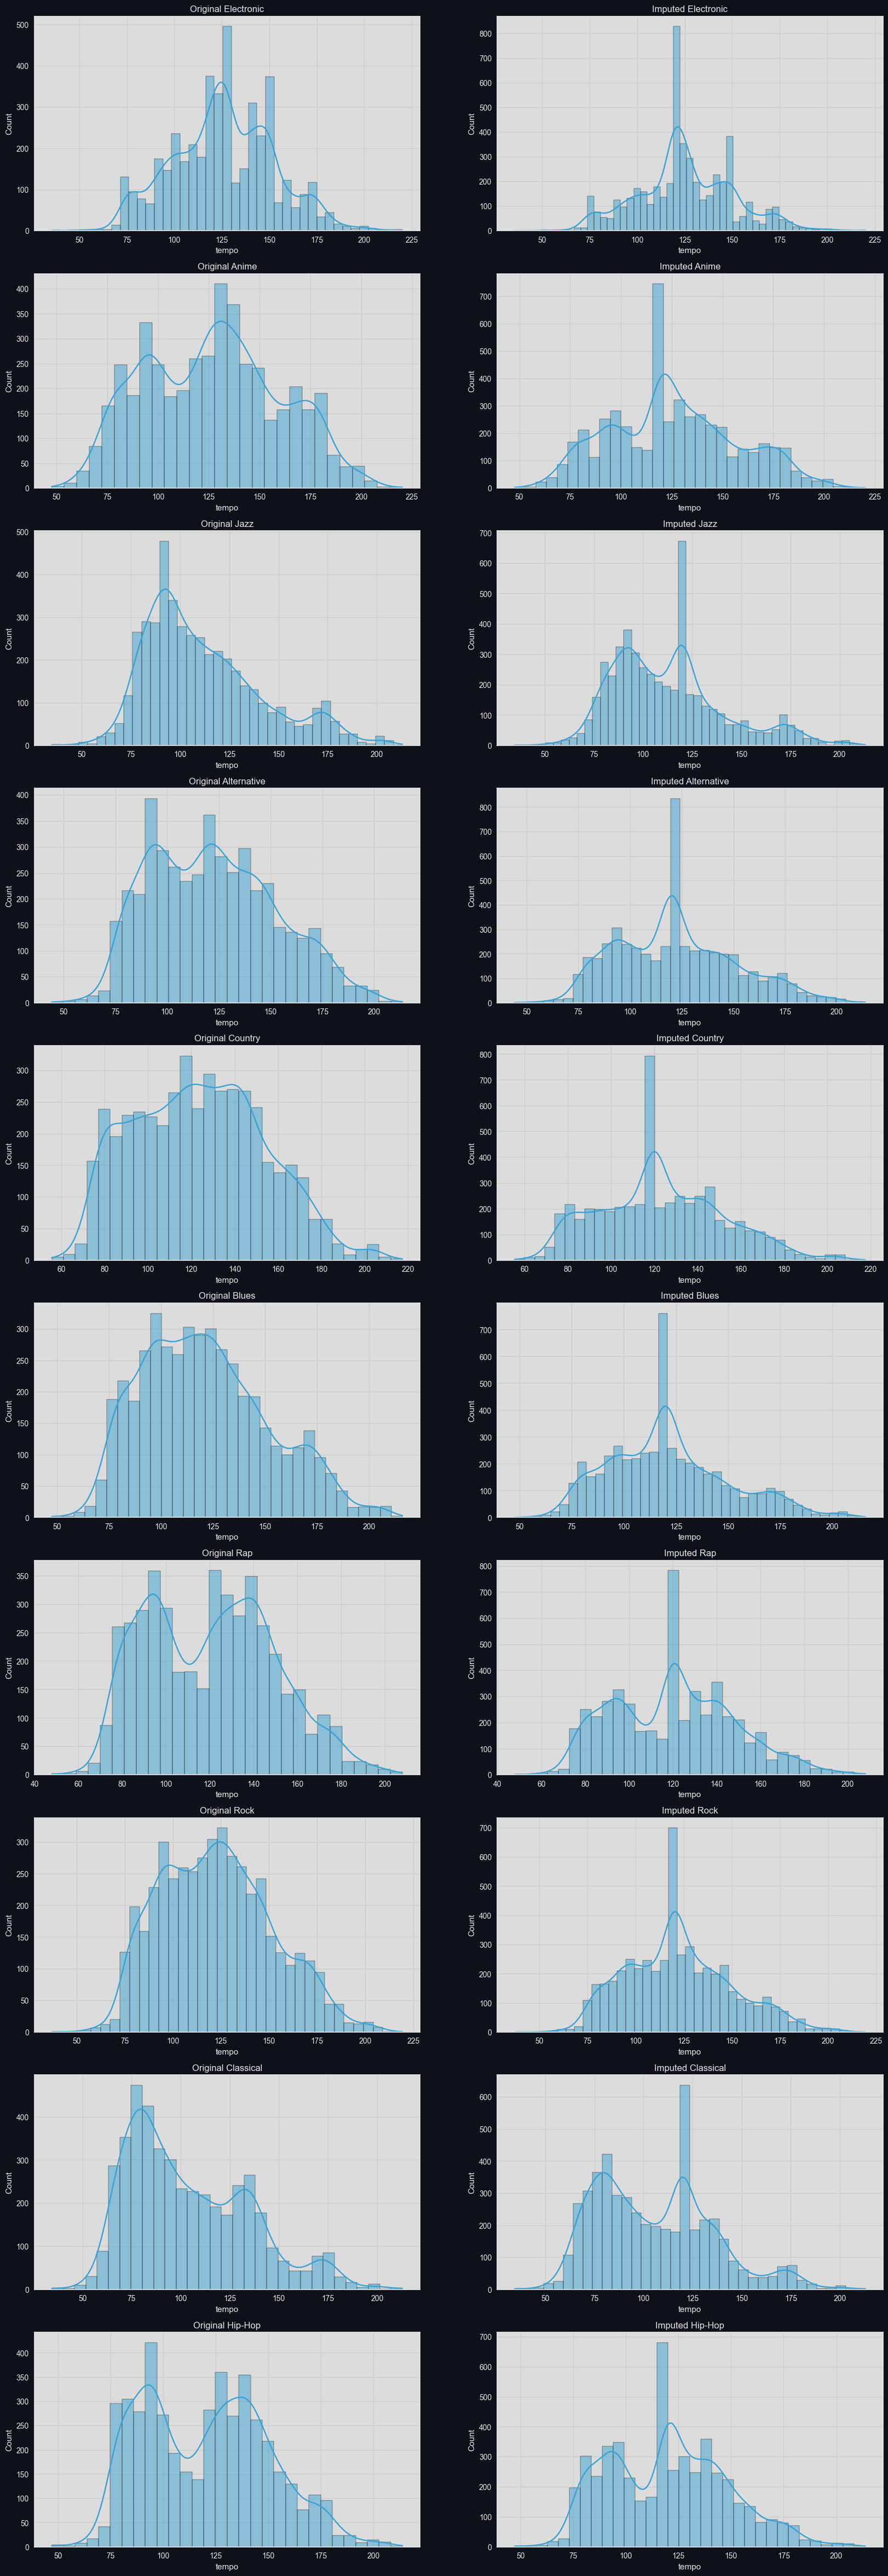

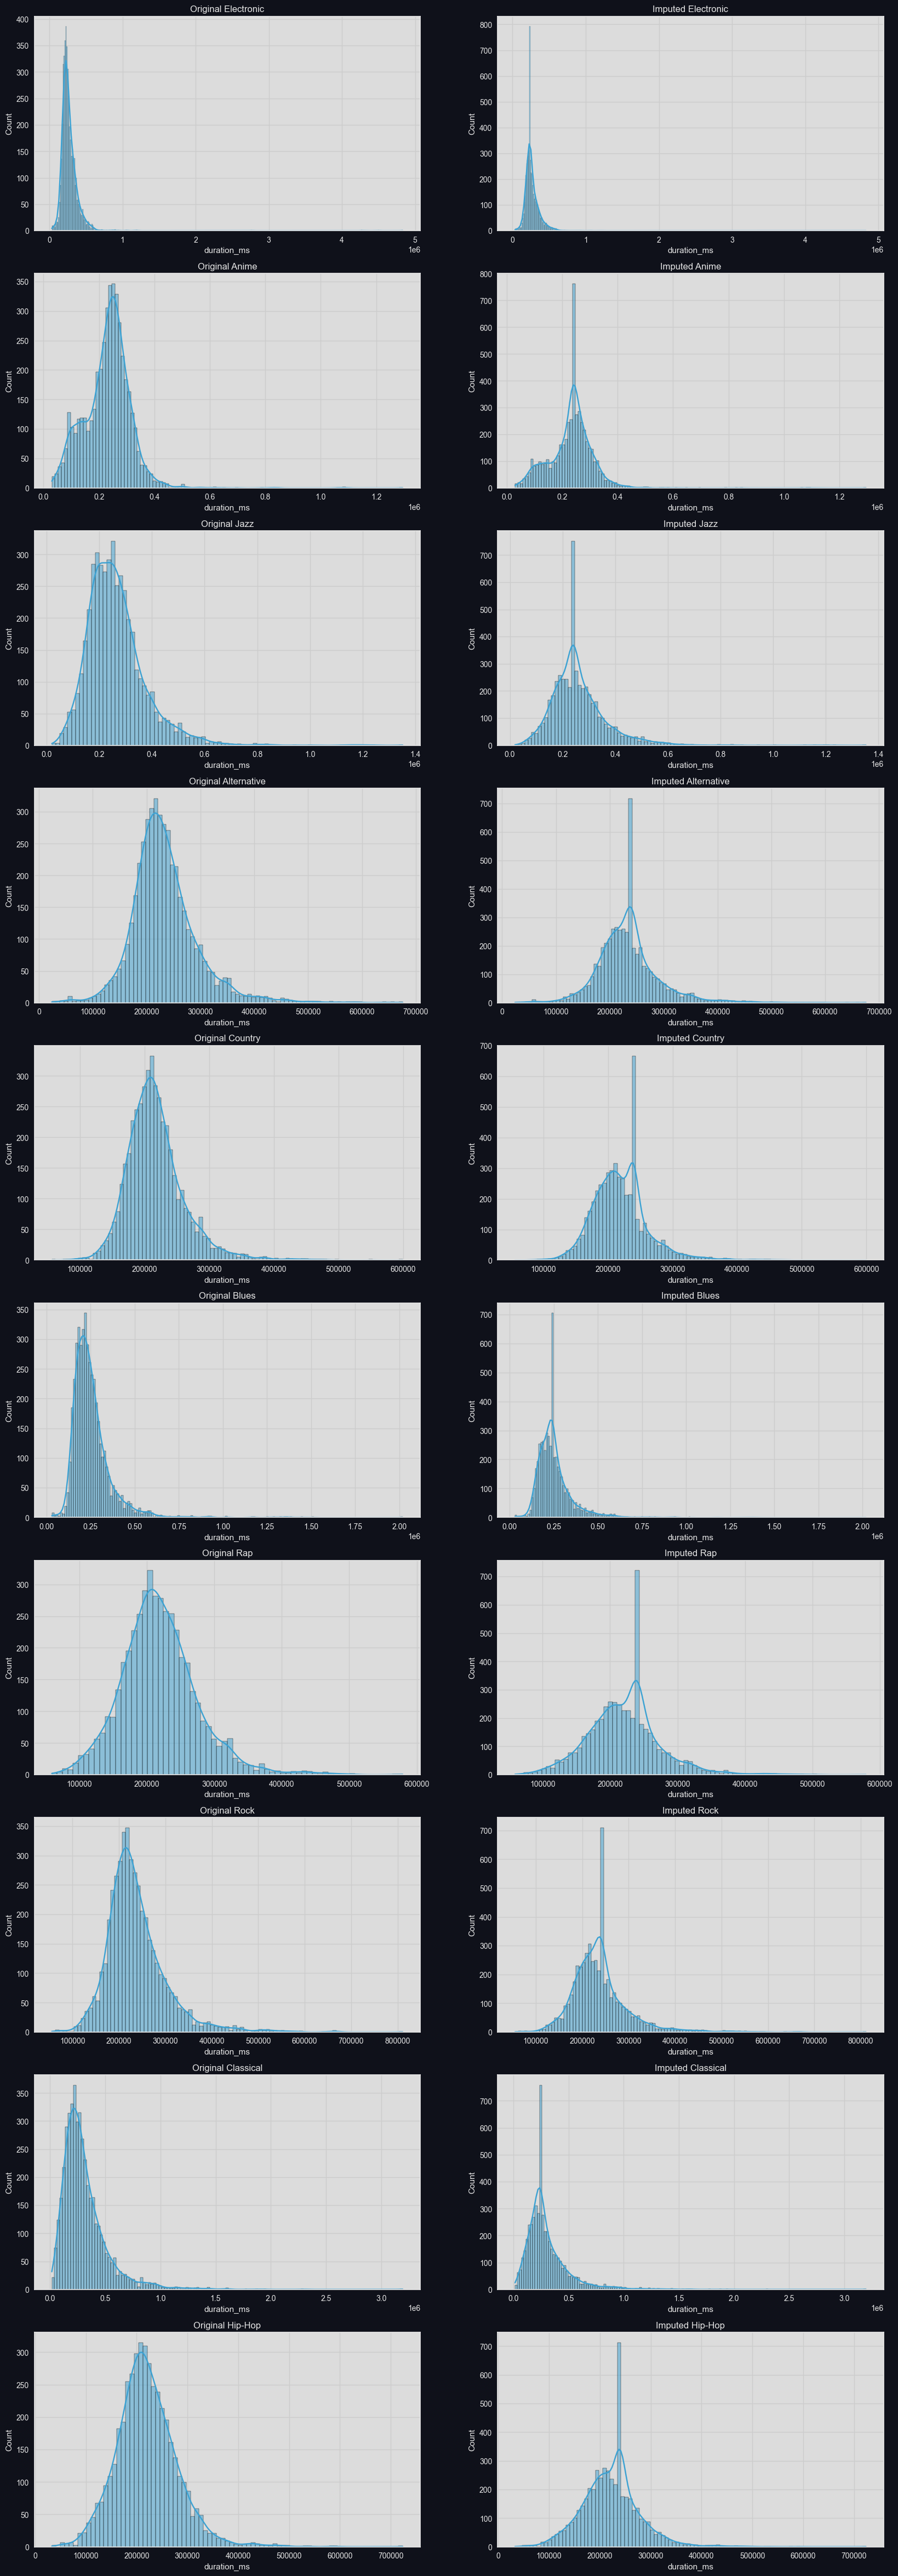

In [14]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_impute_mode = df_impute.copy()
df_impute_mode['tempo'] = imp_mode.fit_transform(df_impute_mode[['tempo']])
df_impute_mode['duration_ms'] = imp_mode.fit_transform(df_impute_mode[['duration_ms']])
imputeHists_mode_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mode, ['Original ','Imputed '])
imputeHists_mode_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mode, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is not quite the same as before. So we decided not to use the mean and the most frequent value to impute the missing values.

#### **Imputation Using Multivariate Imputation by Chained Equations(mice)**

In [15]:
from impyute.imputation.cs import mice

df_impute_mice = df_impute.copy()
df_impute_mice.drop(['key','mode','music_genre'], axis=1, inplace=True)
imputed_training=mice(df_impute_mice.values)

In [16]:
df_impute_mice = pd.DataFrame(imputed_training, columns=df_impute_mice.columns)
df_impute_mice['key'] = df_impute['key']
df_impute_mice['mode'] = df_impute['mode']
df_impute_mice['music_genre'] = df_impute['music_genre']
df_impute_mice

popularity  acousticness  danceability    duration_ms  energy  \
0            27.0       0.00468         0.652  253256.337639   0.941   
1            31.0       0.01270         0.622  218293.000000   0.890   
2            28.0       0.00306         0.620  215613.000000   0.755   
3            34.0       0.02540         0.774  166875.000000   0.700   
4            32.0       0.00465         0.638  222369.000000   0.587   
...           ...           ...           ...            ...     ...   
49995        59.0       0.03340         0.913  209365.433889   0.574   
49996        72.0       0.15700         0.709  251860.000000   0.362   
49997        51.0       0.00597         0.693  189483.000000   0.763   
49998        65.0       0.08310         0.782  262773.000000   0.472   
49999        67.0       0.10200         0.862  267267.000000   0.642   

       instrumentalness  liveness  loudness  speechiness    tempo  valence  \
0               0.79200     0.115    -5.201       0.0748  100.889    0.759   
1               0.95000     0.124    -7.043       0.0300  115.002    0.531   
2               0.01180     0.534    -4.617       0.0345  127.994    0.333   
3               0.00253     0.157    -4.498       0.2390  128.014    0.270   
4               0.90900     0.157    -6.266       0.0413  145.036    0.323   
...                 ...       ...       ...          ...      ...      ...   
49995           0.00000     0.119    -7.022       0.2980   98.028    0.330   
49996           0.00000     0.109    -9.814       0.0550  122.043    0.113   
49997           0.00000     0.143    -5.443       0.1460  131.079    0.395   
49998           0.00000     0.106    -5.016       0.0441   75.886    0.354   
49999           0.00000     0.272   -13.652       0.1010   99.201    0.765   

      key   mode music_genre  
0      A#  Minor  Electronic  
1       D  Minor  Electronic  
2      G#  Major  Electronic  
3      C#  Major  Electronic  
4      F#  Major  Electronic  
...    ..    ...         ...  
49995  C#  Major     Hip-Hop  
49996   B  Major     Hip-Hop  
49997   D  Major     Hip-Hop  
49998   G  Minor     Hip-Hop  
49999  F#  Minor     Hip-Hop  

[50000 rows x 14 columns]

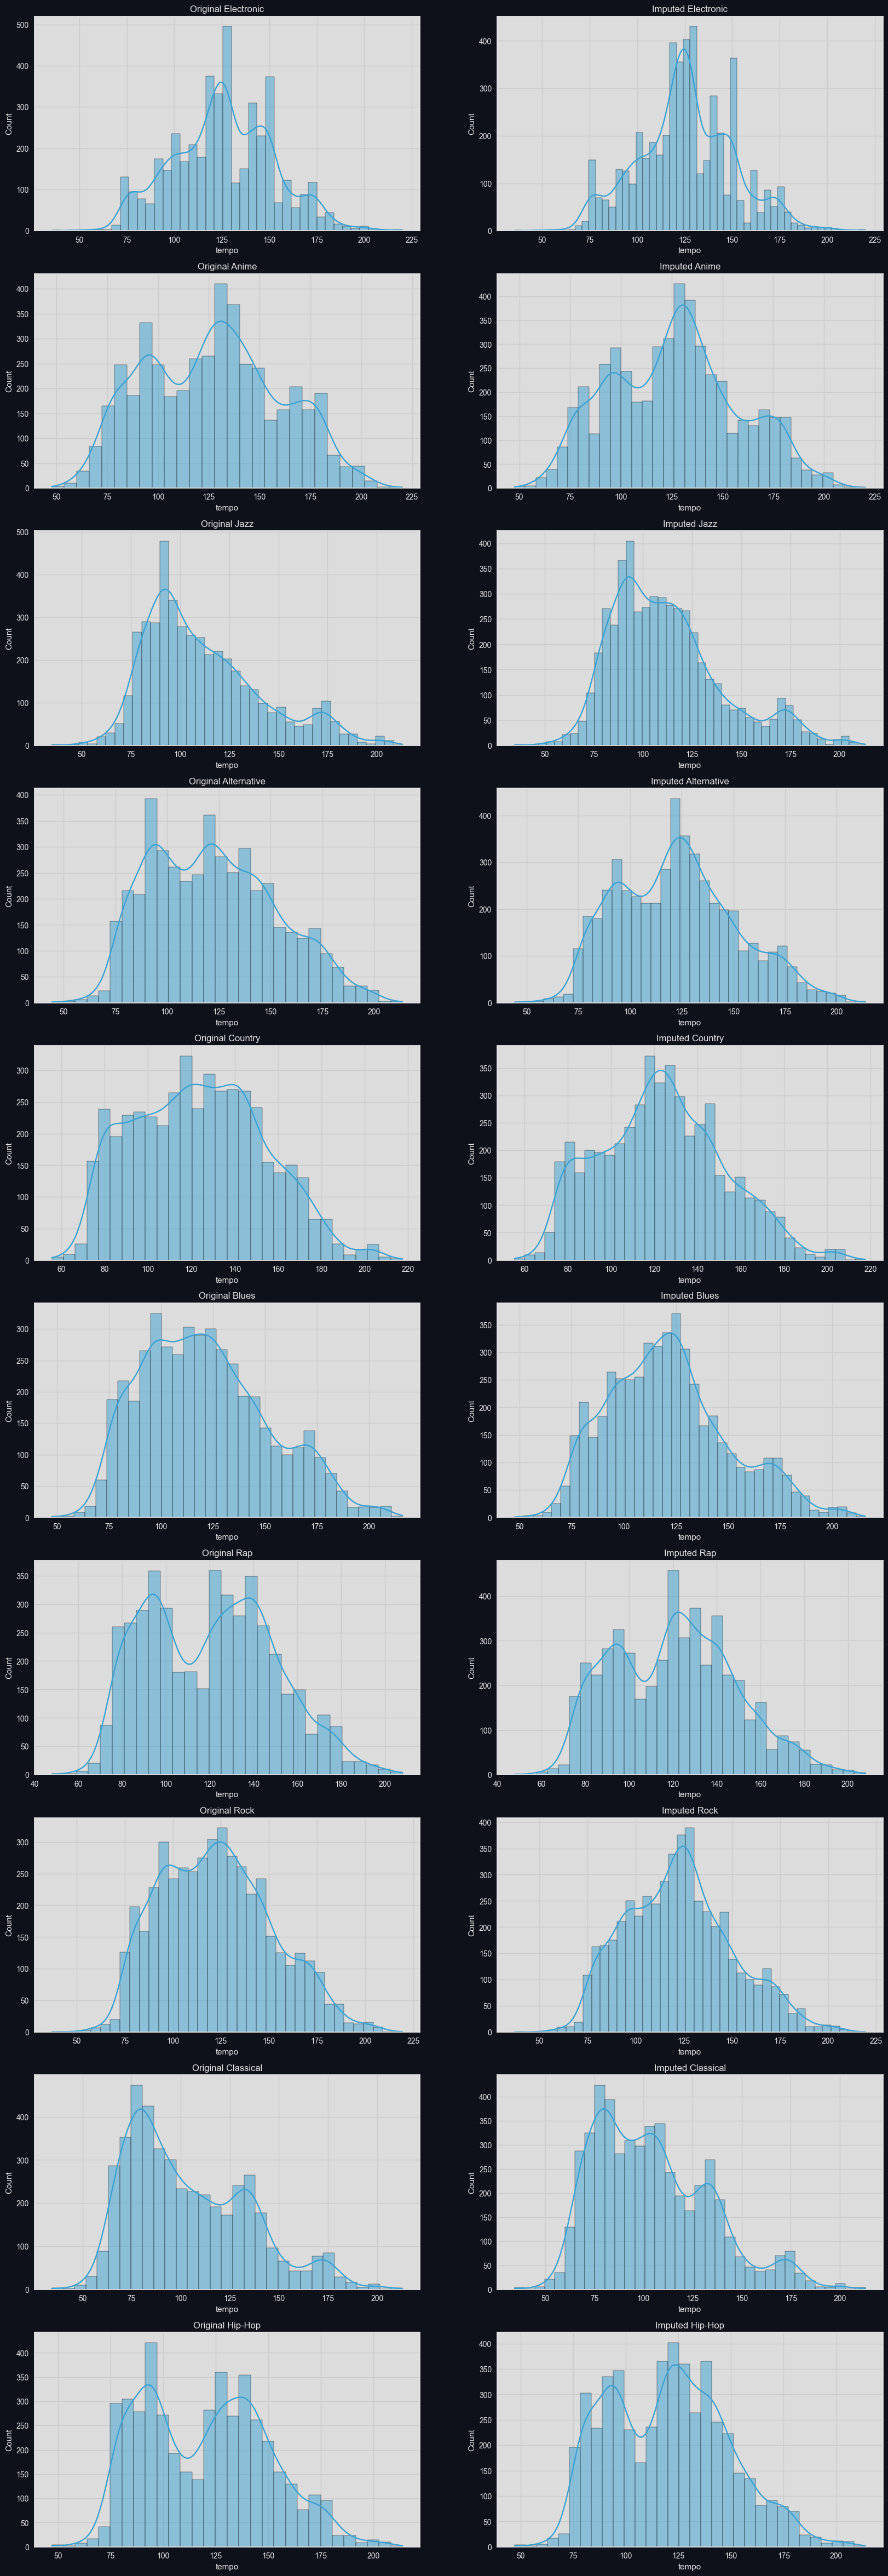

In [17]:
imputeHists_mice_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mice, ['Original ','Imputed '])

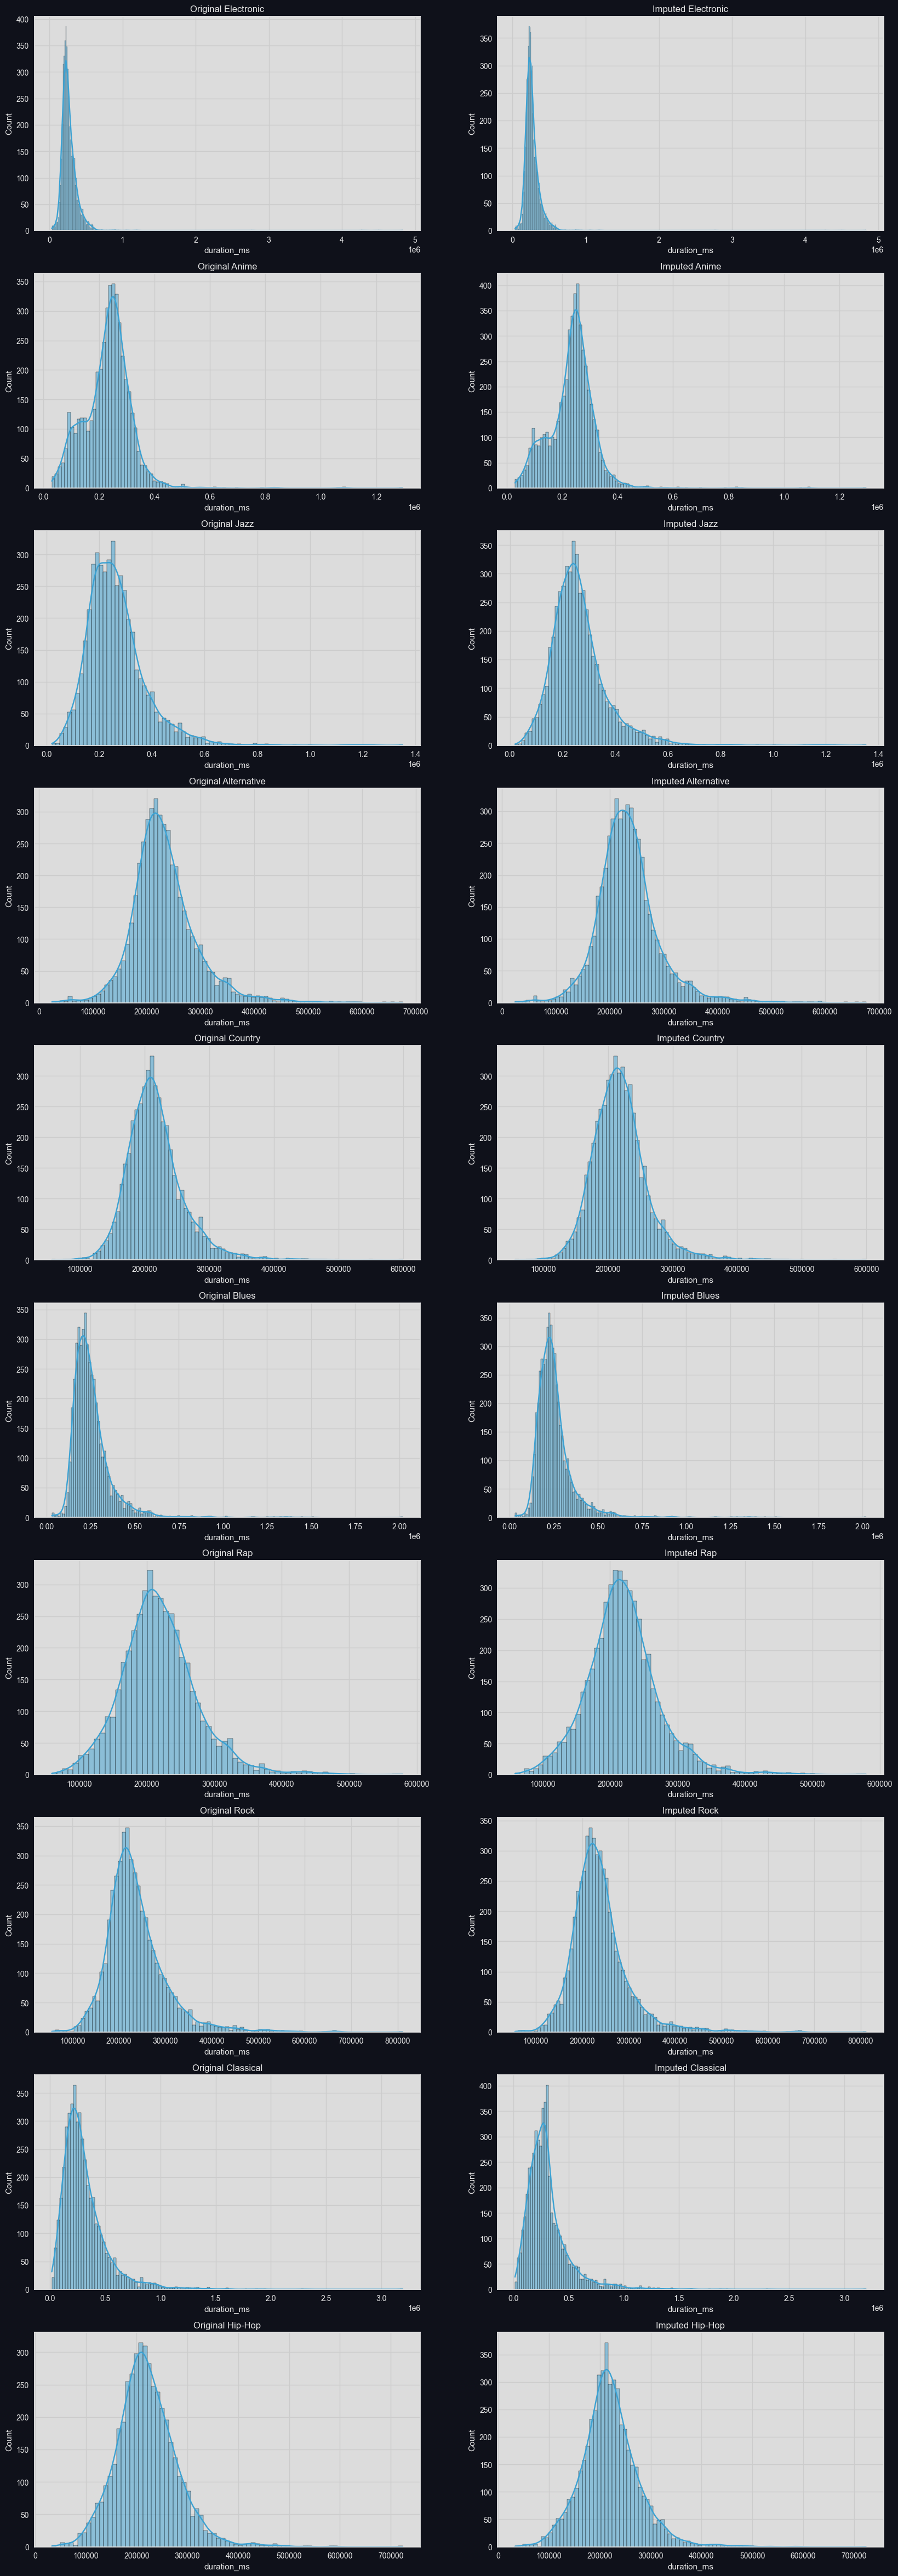

In [18]:
imputeHists_mice_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mice, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is quite the same as before. So we decided to use the mice to impute the missing values.

#### **Imputation Using KNNImputer**

##### **Search for Hyperparameter**

In [19]:
# Impute missing values
df_impute_knn_find = df_impute.copy()
df_impute_knn_find = pd.get_dummies(df_impute_knn_find, columns=['key','mode'], drop_first=True).dropna()

In [20]:
X = df_impute_knn_find.drop(['music_genre'], axis=1)
y = df_impute_knn_find['music_genre']
colX = X.columns
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))
scaler = StandardScaler()
X = scaler.fit_transform(X)

KN_param = [{ 'n_neighbors' : range(0,6,1),
             'weights' : ['uniform', 'distance'],
              }]

KN_clf = KNeighborsClassifier(n_jobs=-1)

f1sc = make_scorer(f1_score, average='weighted')

grid_KN_clf = GridSearchCV(KN_clf, 
                        KN_param,
                        scoring=f1sc, 
                        refit=True,
                        cv=4,
                        n_jobs=-1,
                        verbose=3,
                        return_train_score=True)

In [21]:
grid_KN_clf.fit(X, y)
print("tuned hpyerparameters :(best parameters) ",grid_KN_clf.best_params_)
print("score :",grid_KN_clf.best_score_)

"""
Fitting 4 folds for each of 12 candidates, totalling 48 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 3, 'weights': 'uniform'}
score : 0.41099356419921224

Fitting 4 folds for each of 12 candidates, totalling 48 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 5, 'weights': 'uniform'}
score : 0.4450642884772404

Fitting 4 folds for each of 22 candidates, totalling 88 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 10, 'weights': 'uniform'}
score : 0.4686828275311239

Fitting 4 folds for each of 22 candidates, totalling 88 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 30, 'weights': 'uniform'}
score : 0.4754055746692795
"""

Fitting 4 folds for each of 12 candidates, totalling 48 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 5, 'weights': 'uniform'}
score : 0.4450642884772404


"\nFitting 4 folds for each of 12 candidates, totalling 48 fits\ntuned hpyerparameters :(best parameters)  {'n_neighbors': 3, 'weights': 'uniform'}\nscore : 0.41099356419921224\n\nFitting 4 folds for each of 12 candidates, totalling 48 fits\ntuned hpyerparameters :(best parameters)  {'n_neighbors': 5, 'weights': 'uniform'}\nscore : 0.4450642884772404\n\nFitting 4 folds for each of 22 candidates, totalling 88 fits\ntuned hpyerparameters :(best parameters)  {'n_neighbors': 10, 'weights': 'uniform'}\nscore : 0.4686828275311239\n\nFitting 4 folds for each of 22 candidates, totalling 88 fits\ntuned hpyerparameters :(best parameters)  {'n_neighbors': 30, 'weights': 'uniform'}\nscore : 0.4754055746692795\n"

โดยหลังจากที่นำค่า K ที่เป็นไปได้มาทดลองแล้ว จะพบว่า ค่า K ที่ดีที่สุดคือ 3 ที่จะใช้ Histogram ในการทำ Imputation ให้มีการกระจายของข้อมูลใกล้เคียงกับข้อมูลตั้งต้นมากที่สุด ทั้งนี้ด้วยความที่ KNN เป็น Model ที่ได้รับผลกระทบจาก Outlier ค่อนข้างมากเมื่อ K เพิ่มขึ้น ด้วยเหตุที่ว่า มี Bias ที่สูงและ Variance ที่ต่ำ จึงเลือกใช้ K ที่เล็กที่สุด 3 ในการทำ Imputation

##### **Impute**

In [22]:
# Impute missing values
df_impute_knn = df_impute.copy()
df_impute_knn = pd.get_dummies(df_impute_knn, columns=['key','mode','music_genre'], drop_first=True)
col_knn = df_impute_knn.columns

In [23]:
scaler_knnimpute = StandardScaler()
df_impute_knn = pd.DataFrame(scaler_knnimpute.fit_transform(df_impute_knn), columns=col_knn)
KNNimputer = KNNImputer(n_neighbors=3, weights="uniform")
df_impute_knn = pd.DataFrame(KNNimputer.fit_transform(df_impute_knn), columns=col_knn)
df_impute_knn = pd.DataFrame(scaler_knnimpute.inverse_transform(df_impute_knn), columns=col_knn)

In [24]:
duration_ms = df_impute_knn['duration_ms']
tempo = df_impute_knn['tempo']
df_impute_knn = df_impute.copy()
df_impute_knn['duration_ms'] = duration_ms
df_impute_knn['tempo'] = tempo
df_impute_knn

popularity  acousticness  danceability    duration_ms  energy  \
0            27.0       0.00468         0.652  265662.333333   0.941   
1            31.0       0.01270         0.622  218293.000000   0.890   
2            28.0       0.00306         0.620  215613.000000   0.755   
3            34.0       0.02540         0.774  166875.000000   0.700   
4            32.0       0.00465         0.638  222369.000000   0.587   
...           ...           ...           ...            ...     ...   
49995        59.0       0.03340         0.913  210142.333333   0.574   
49996        72.0       0.15700         0.709  251860.000000   0.362   
49997        51.0       0.00597         0.693  189483.000000   0.763   
49998        65.0       0.08310         0.782  262773.000000   0.472   
49999        67.0       0.10200         0.862  267267.000000   0.642   

       instrumentalness  liveness  loudness  speechiness    tempo  valence  \
0               0.79200     0.115    -5.201       0.0748  100.889    0.759   
1               0.95000     0.124    -7.043       0.0300  115.002    0.531   
2               0.01180     0.534    -4.617       0.0345  127.994    0.333   
3               0.00253     0.157    -4.498       0.2390  128.014    0.270   
4               0.90900     0.157    -6.266       0.0413  145.036    0.323   
...                 ...       ...       ...          ...      ...      ...   
49995           0.00000     0.119    -7.022       0.2980   98.028    0.330   
49996           0.00000     0.109    -9.814       0.0550  122.043    0.113   
49997           0.00000     0.143    -5.443       0.1460  131.079    0.395   
49998           0.00000     0.106    -5.016       0.0441   75.886    0.354   
49999           0.00000     0.272   -13.652       0.1010   99.201    0.765   

      key   mode music_genre  
0      A#  Minor  Electronic  
1       D  Minor  Electronic  
2      G#  Major  Electronic  
3      C#  Major  Electronic  
4      F#  Major  Electronic  
...    ..    ...         ...  
49995  C#  Major     Hip-Hop  
49996   B  Major     Hip-Hop  
49997   D  Major     Hip-Hop  
49998   G  Minor     Hip-Hop  
49999  F#  Minor     Hip-Hop  

[50000 rows x 14 columns]

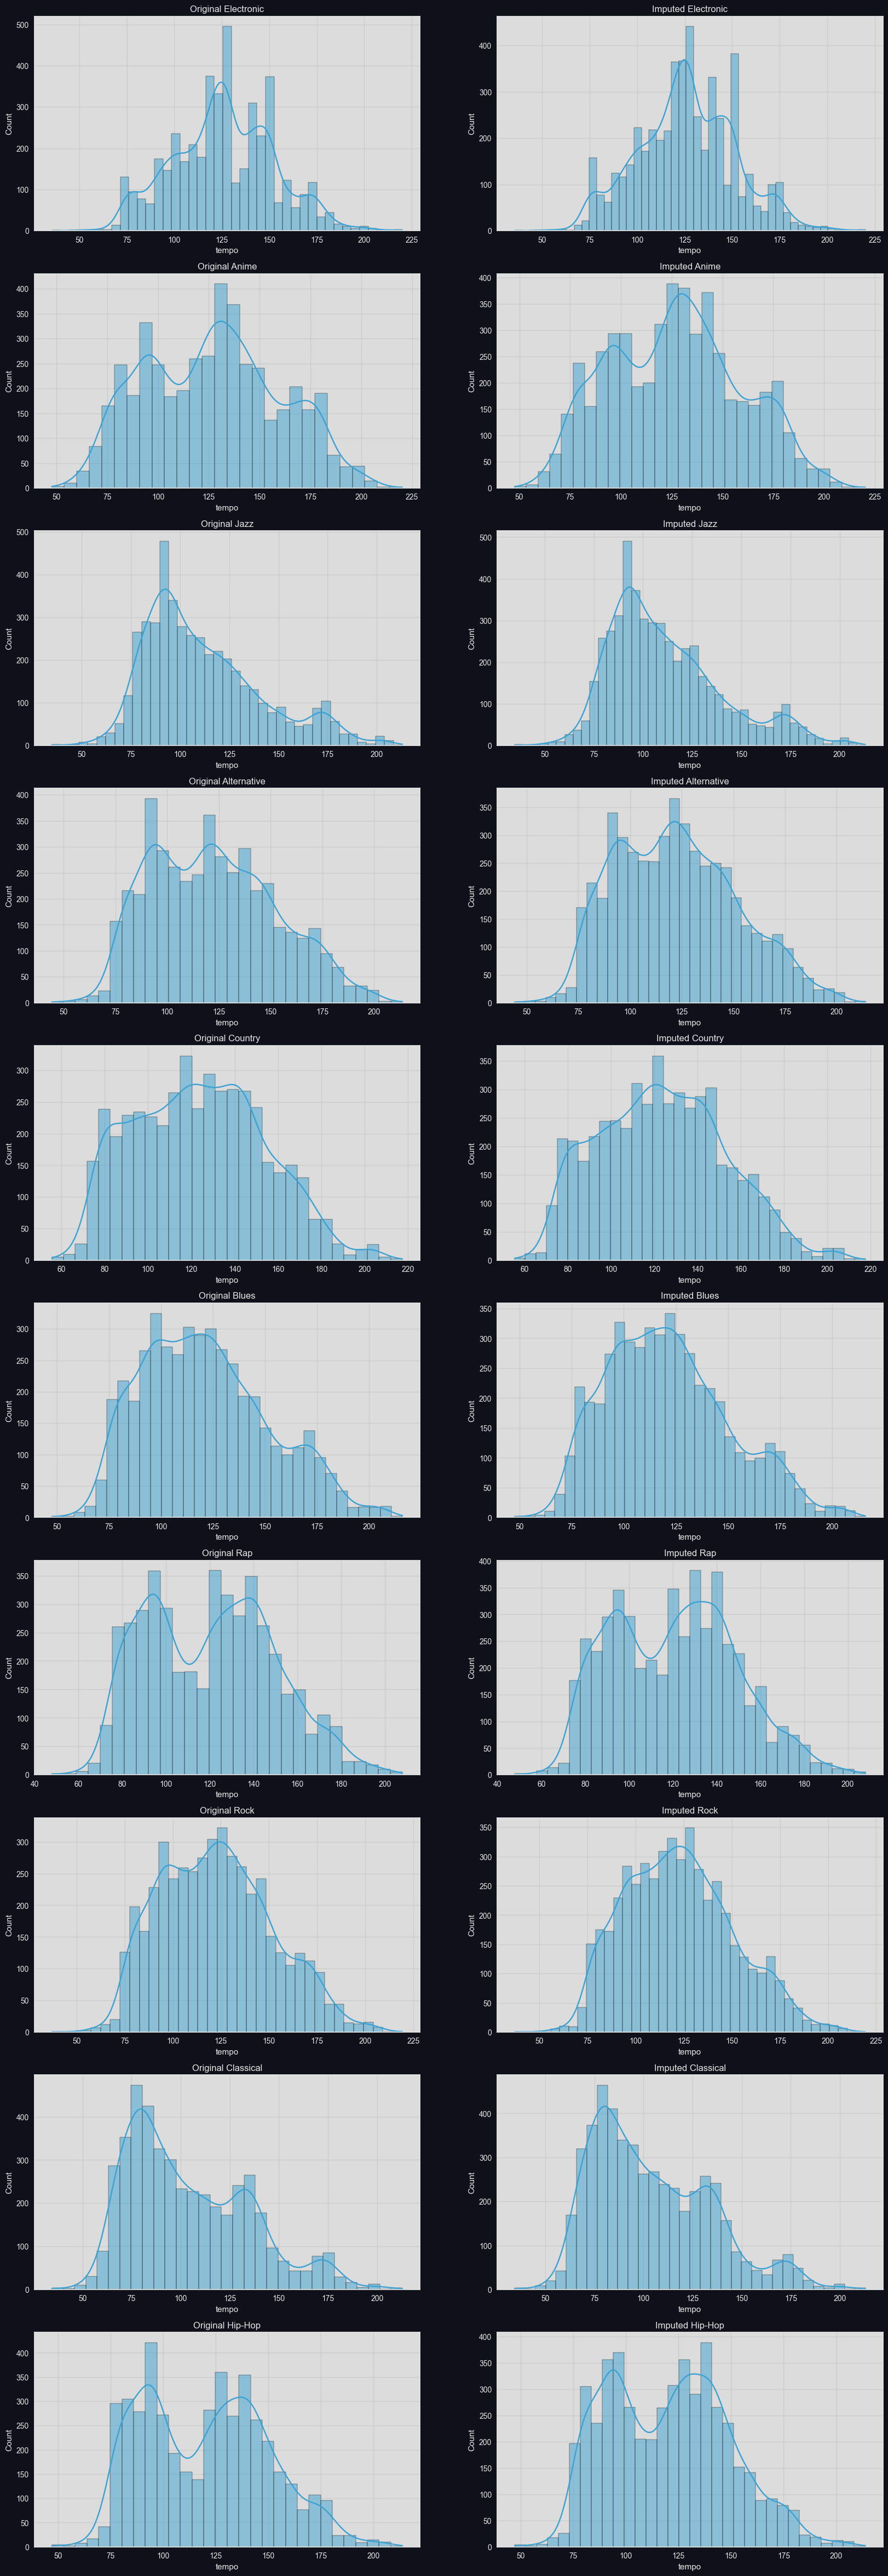

In [25]:
imputeHists_KNN_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_knn, ['Original ','Imputed '])

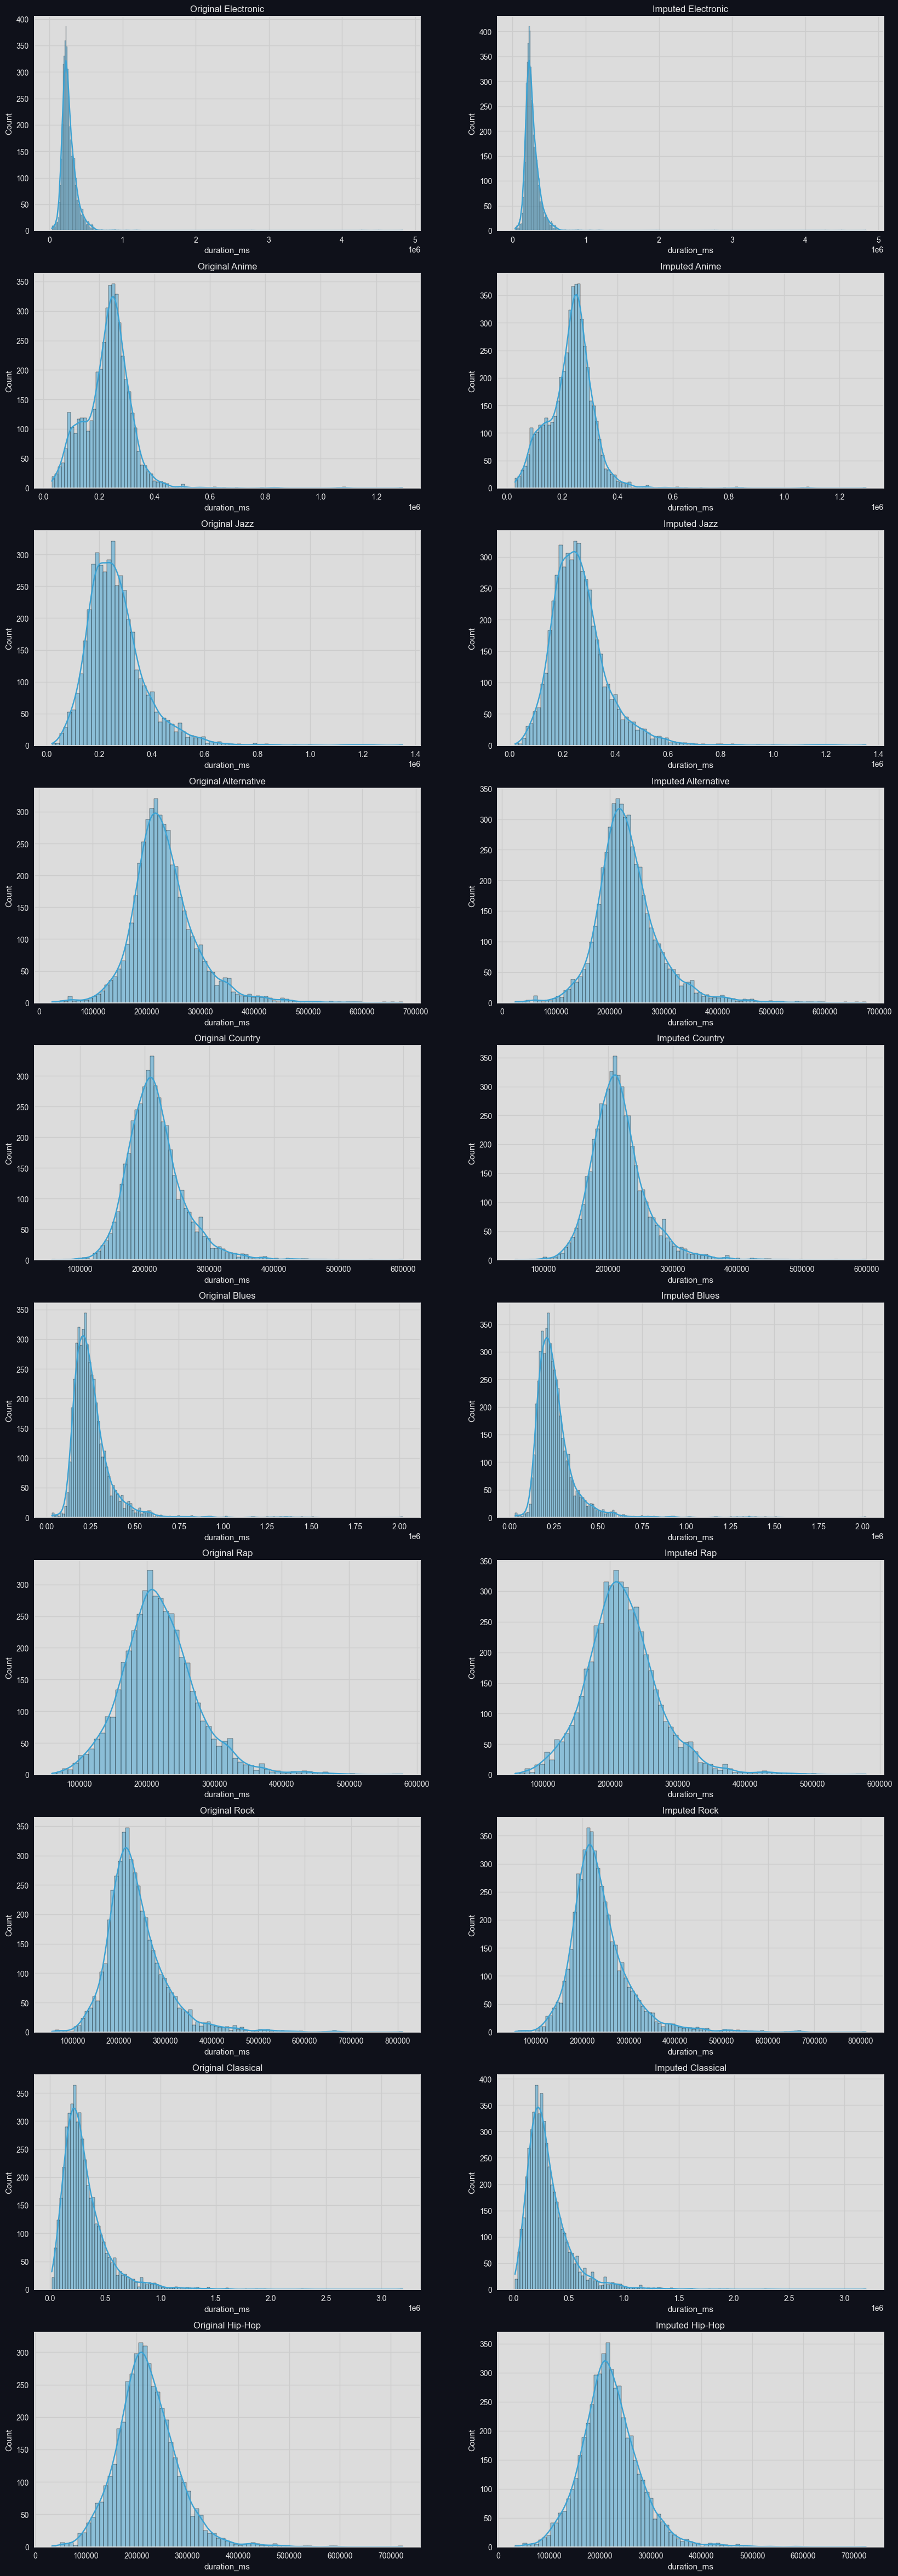

In [26]:
imputeHists_KNN_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_knn, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is quite the same as before. So we decided to use the KNNImputer to impute the missing values.

#### **Conclusion**

เนื่องจากการทำ Imputation ด้วย KNNImputer และ mice ได้ผลลัพธ์ที่ใกล้เคียงกับข้อมูลตั้งต้นมาก เราจะพิจารณาถึง Histogram ของข้อมูลโดยรวมและ Outlier ของข้อมูลเพิ่มเติม

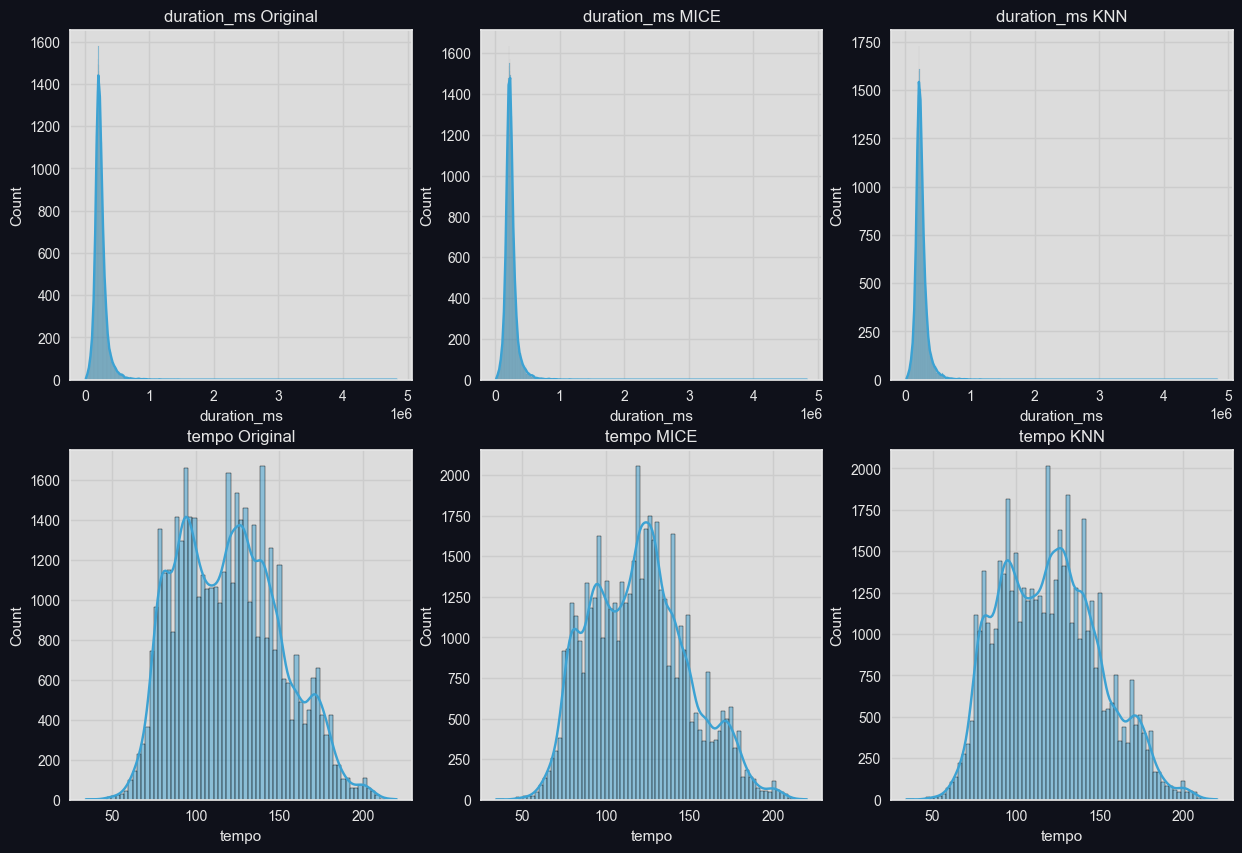

In [27]:
coltoplot = ['duration_ms','tempo']
dftoplot = [df_vis, df_impute_mice, df_impute_knn]
titlelist = ['Original','MICE','KNN']
NumHists_knn, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, df in enumerate(dftoplot):
    for j, col in enumerate(coltoplot):
        ax = axes[j, i]
        sns.histplot(df[col], ax=ax, color=snsPalette[0], kde=True)
        ax.set_title(f'{col} '+titlelist[i])
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.set_facecolor(axBGColor)

In [28]:
outlierplotstripOriginal = plotoutlierBarStrip(df_vis, 'Original','strip','notdetail')

NameError: name 'plotoutlierBarStrip' is not defined

In [ ]:
outlierplotstripMice = plotoutlierBarStrip(df_impute_mice, 'KNN Impute','strip','notdetail')

In [ ]:
outlierplotstripKNNimpute = plotoutlierBarStrip(df_impute_knn, 'KNN Impute','strip','notdetail')

หลังจากพิจารณา Histogram ของข้อมูลโดยรวมและ Outlier ของข้อมูลแล้วพอว่าผลลัพธ์ที่ได้จากการทำ Imputation ด้วย KNNImputer มีความถูกต้องมากกว่าการทำ Imputation ด้วย Mean, Most Frequent และ mice จึงเลือกใช้ KNNImputer ในการทำ Imputation เป็นผลลัพธ์สุดท้าย

In [ ]:
df_impute_knn.to_csv('Data/df_impute_knn.csv', index=False)